In [1]:
%load_ext autoreload
%autoreload 2

import torch as t
import requests
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [2]:
device = t.device("cuda:3" if t.cuda.is_available() else "cpu")

In [3]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten').to(device)

2024-03-21 22:48:28.086716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 22:48:28.086742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 22:48:28.087430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 22:48:28.090977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 22:48:28.595134: W tensorflow/compiler/tf2

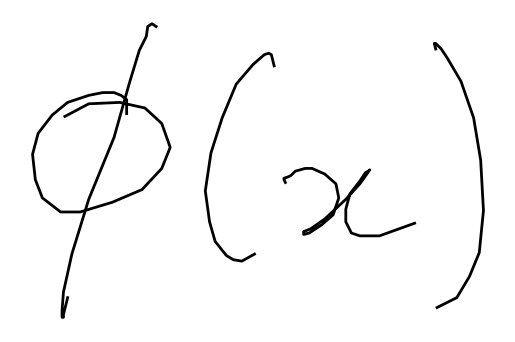

In [4]:
raw_image = Image.open("../img_data/inkML_data_CROHME_training_2011_formulaire001-equation001.inkml_0.png").convert('RGB')
raw_image

### Before Finetuning:

In [5]:
pixel_values = processor(images = raw_image, return_tensors="pt").pixel_values.to(device)
generated_ids = model.generate(pixel_values)
print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

/home/will/.conda/envs/torch2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


p ( see ).


### Pretraining step on large dataset (rendered LaTeX)

#### Process data (run ONCE!)

In [10]:
# Load LST files
import pandas as pd
import numpy as np
import re
from tqdm import tqdm, trange

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

train_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_train.lst", sep=" ", index_col = 0, header = None)
val_filenames_df = pd.read_csv("../rendered_LaTeX/im2latex_validate.lst", sep=" ", index_col = 0, header = None)
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()
invalid_train_images = []
for index in tqdm(train_filenames_df.index):
    formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[index, 1] + ".png").convert('RGBA')
    try: crop_to_formula(formula_image_example)
    except: invalid_train_images.append(index)
print("Invalid train images: ", len(invalid_train_images))

train_filenames_df = train_filenames_df.drop(invalid_train_images)
invalid_val_images = []
for index in tqdm(val_filenames_df.index):
    formula_image_example = Image.open("../formula_images/" + val_filenames_df.loc[index, 1] + ".png").convert('RGBA')
    try: crop_to_formula(formula_image_example)
    except: invalid_val_images.append(index)
val_filenames_df = val_filenames_df.drop(invalid_val_images)
print("Invalid val images: ", len(invalid_val_images))

invalid_idxs = set(invalid_train_images + invalid_val_images)

formulas = [i for index, i in enumerate(formulas) if index not in invalid_idxs]

print("Number of training formulas: ", len(train_filenames_df))
print("Number of validation formulas: ", len(val_filenames_df))
max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

  0%|          | 4/83884 [00:00<40:12, 34.77it/s]

100%|██████████| 83884/83884 [41:06<00:00, 34.02it/s]


Invalid train images:  229


100%|██████████| 9320/9320 [04:31<00:00, 34.35it/s]

Invalid val images:  23
Number of training formulas:  83655
Number of validation formulas:  9297


AssertionError: 

#### Training:

In [6]:
# Load LST files
import pandas as pd
import numpy as np
import re
from tqdm import tqdm, trange

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

train_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_train.lst", index_col = 0, header = None, sep = " ")
val_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_val.lst", index_col = 0, header = None, sep = " ")
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()

print("Number of training formulas: ", len(train_filenames_df))
print("Number of validation formulas: ", len(val_filenames_df))

max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

Number of training formulas:  83655
Number of validation formulas:  9296
Max length: 998


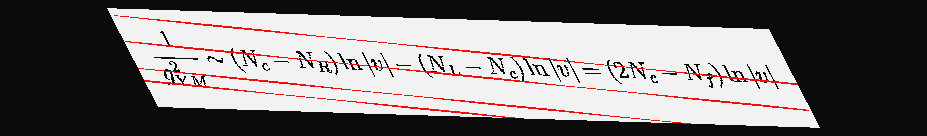

<IPython.core.display.Math object>

\frac{1}{g_{YM}^2} \sim (N_c - N_R) \ln |v| - (N_L - N_c) \ln |v| = (2N_c - N_f) \ln |v|



In [136]:
import torchvision.transforms as transforms
train_transforms = transforms.Compose([
    transforms.v2.RandomAffine(degrees = 5,
                               scale = (0.7, 1.1),
                               shear = 30),
    transforms.v2.ColorJitter(brightness = 0.2,
                              contrast = 0.2,
                              saturation = 0.2,
                              hue = 0.1)
])
random_idx = np.random.choice(train_filenames_df.index)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[random_idx, 1] + ".png").convert('RGBA')

from IPython.display import display, Math, Latex

display(train_transforms(crop_to_formula(formula_image_example)))
display_formula(renderedLaTeXLabelstr2Formula(formulas[random_idx]))
print(renderedLaTeXLabelstr2Formula(formulas[random_idx]))

<Axes: ylabel='Count'>

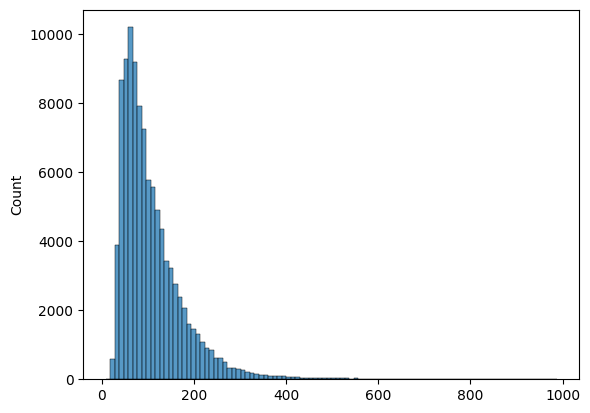

In [17]:
import seaborn as sns
formula_lengths = [len(renderedLaTeXLabelstr2Formula(formula)) for formula in formulas]
sns.histplot(formula_lengths, bins = 100)

In [10]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.transforms.v2
from sklearn.model_selection import train_test_split
import sklearn as skl

from data.datasets import renderedLaTeXDataset, set_seed
from data.dataset_tests import test_renderedLaTeXDataset

# Hyperparams
NUM_EPOCHS = 2
LEARNING_RATE = 1e-5
BATCH_SIZE = 4 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_ds = renderedLaTeXDataset(image_folder = "../formula_images/", 
                                lst_file = "../rendered_LaTeX/processed_im2latex_train.lst", 
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst", 
                                device = device,
                                processor = processor,
                                transforms = train_transforms)
val_ds = renderedLaTeXDataset(image_folder = "../formula_images/",
                                lst_file = "../rendered_LaTeX/processed_im2latex_val.lst",
                                formulas_file = "../rendered_LaTeX/im2latex_formulas.lst",
                                device = device,
                                processor = processor)
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = SHUFFLE_DATASET, num_workers = 0)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

test_renderedLaTeXDataset(train_ds, processor = processor)
test_renderedLaTeXDataset(val_ds, processor = processor)

print("Number of training samples:", len(train_ds))
print("Number of validation samples:", len(val_ds))

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

renderedLaTeXDataset tests passed.
renderedLaTeXDataset tests passed.
Number of training samples: 83655
Number of validation samples: 9296


In [11]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.95
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/2:   0%|          | 0/20914 [00:00<?, ?it/s]

Epoch 1/2:   3%|▎         | 683/20914 [05:56<2:55:55,  1.92it/s, loss=0.486]


KeyboardInterrupt: 

In [ ]:
# Save model
model.save_pretrained("../models/trocr-large-rendered-im2latex")
processor.save_pretrained("../models/trocr-large-rendered-im2latex")

#### Validation

In [5]:
# Load LST files
import pandas as pd
import numpy as np
import re
from tqdm import tqdm, trange

import sys, os
sys.path.append(os.path.abspath('../'))
from utils.latex import crop_to_formula, renderedLaTeXLabelstr2Formula, display_formula

train_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_train.lst", index_col = 0, header = None, sep = " ")
val_filenames_df = pd.read_csv("../rendered_LaTeX/processed_im2latex_val.lst", index_col = 0, header = None, sep = " ")
formulas = open("../rendered_LaTeX/im2latex_formulas.lst", encoding = "ISO-8859-1", newline="\n").readlines()

print("Number of training formulas: ", len(train_filenames_df))
print("Number of validation formulas: ", len(val_filenames_df))

max_len = max([len(formula) for formula in formulas])
print("Max length:", max_len)

Number of training formulas:  83655
Number of validation formulas:  9296
Max length: 998


In [6]:
model = VisionEncoderDecoderModel.from_pretrained("../models/trocr-large-rendered-im2latex").to(device)
processor = TrOCRProcessor.from_pretrained("../models/trocr-large-rendered-im2latex")

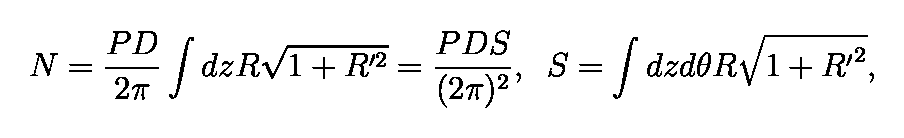

<IPython.core.display.Math object>

N=\frac{PD}{2\pi}\int dz R\sqrt{1+R^{\prime 2}}=\frac{PDS}{(2\pi)^2},\;\;S=\int dz d\theta R\sqrt{1+{R^{\prime}}^2},



<IPython.core.display.Math object>

N=\frac{PD}{2\pi} \int dz R \sqrt{1+R'^2}=\frac{PDS}{(2\pi)^2},\;\;S=\int dz d\theta R \sqrt{1+R'^2},



In [65]:
random_idx = np.random.choice(train_filenames_df.index)
formula_image_example = Image.open("../formula_images/" + train_filenames_df.loc[random_idx, 1] + ".png").convert('RGBA')

display(crop_to_formula(formula_image_example))
from IPython.display import display, Math, Latex
display_formula(renderedLaTeXLabelstr2Formula(formulas[random_idx]))
print(renderedLaTeXLabelstr2Formula(formulas[random_idx]))

model_prediction = model.generate(processor(images = crop_to_formula(formula_image_example), return_tensors="pt").pixel_values.to(device), max_new_tokens = 512)
str_pred = processor.batch_decode(model_prediction, skip_special_tokens=True)[0]
display_formula(str_pred)
print(str_pred)

### Finetuning:

In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sklearn as skl

def set_seed(seed):
    np.random.seed(seed)
    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)
    skl.utils.check_random_state(seed)

class MathCaptionsDataset(Dataset):
    """
    A dataset object that loads in images from img_data and captions from labels.csv.

    - Processor: A Huggingface processor object that will be used to process the images and captions.
    - img_dir: The directory containing the images and labels.csv.
    - csv_file: The file containing the captions.
    - transform: A torchvision transform to be applied to the images.
    """
    def __init__(self, processor,
                 img_dir = "../img_data", 
                 csv_file = "labels.csv",
                 transform = None, use_float16 = False,
                 device = device,
                 partition = "train",
                 test_split = 0.2, random_seed = 0):
        
        self.img_dir = img_dir
        self.csv_path = os.path.join(img_dir, csv_file)
        self.labels = pd.read_csv(self.csv_path)
        # Randomly select data_split of the data for training and the rest for validation
        self.labels, self.labels_val = train_test_split(self.labels, test_size = test_split, random_state = random_seed)
        self.partition = partition
        self.transform = transform
        self.processor = processor
        self.use_float16 = use_float16
        self.device = device

    def __len__(self):
        if self.partition == "train": return len(self.labels)
        else: return len(self.labels_val)
    
    def train(self):
        self.partition = "train"
    
    def val(self):
        self.partition = "val"

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        if self.partition == "train": img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])
        else: img_name = os.path.join(self.img_dir, self.labels_val.iloc[idx, 1])

        image = Image.open(img_name).convert('RGB')
        inputs = self.processor(images = image,  padding = "max_length", return_tensors="pt").to(self.device)
        if self.use_float16:
            inputs = inputs.to(t.float16)
        for key in inputs:
            inputs[key] = inputs[key].squeeze() # Get rid of batch dimension since the dataloader will batch it for us.

        if self.partition == "train": caption = self.labels.iloc[idx, 0]
        else: caption = self.labels_val.iloc[idx, 0]
        caption = self.processor.tokenizer.encode(
            caption, return_tensors="pt", padding = "max_length", max_length = 256, # Tweak this, longest length in current dataset is 156
            ).to(self.device).squeeze()

        return inputs, caption

In [6]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

# Hyperparams
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
BATCH_SIZE = 8 # 10 gigs of Vram -> 4, <5 gigs of vram -> 2
SHUFFLE_DATASET = True

set_seed(0)
optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_ds = MathCaptionsDataset(processor); train_ds.train()
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET, num_workers=0)
val_ds = MathCaptionsDataset(processor); val_ds.val()
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
assert (train_ds.labels_val.values == val_ds.labels_val.values).all()

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.to(device)
model.train()
pass

NameError: name 'model' is not defined

In [68]:
history = []; val_history = []; val_timesteps = []
ema_loss = None; ema_alpha = 0.99
scaler = t.cuda.amp.GradScaler(enabled = True)
for epoch in range(NUM_EPOCHS):
    with tqdm(train_dl, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}") as pbar:
        for batch, captions in pbar:
            pixel_values = batch["pixel_values"]
            
            optimizer.zero_grad()
            with t.autocast(device_type = "cuda", dtype = t.float16, enabled = True):
                outputs = model(pixel_values = pixel_values,
                                labels = captions)
                loss = outputs.loss
                history.append(loss.item())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if ema_loss is None: ema_loss = loss.item()
            else: ema_loss = ema_loss * ema_alpha + loss.item() * (1 - ema_alpha)
            pbar.set_postfix(loss=ema_loss)
    
    model.eval()
    with t.no_grad():
        val_losses = []
        for batch, captions in tqdm(val_dl):
            pixel_values = batch["pixel_values"]
            outputs = model(pixel_values = pixel_values,
                            labels = captions)
            val_losses.append(outputs.loss.item())
        print(f"Validation loss: {np.mean(val_losses)}")
        val_history.append(np.mean(val_losses))
        val_timesteps.append(len(history) - 1)

Epoch 1/3:   0%|          | 0/1110 [00:00<?, ?it/s]

100%|██████████| 278/278 [01:46<00:00,  2.61it/s]


Validation loss: 0.016337722931861233


Epoch 2/3:  21%|██        | 232/1110 [02:02<07:45,  1.89it/s, loss=0.0157]


KeyboardInterrupt: 

In [21]:
model.save_pretrained("trocr_model")
processor.save_pretrained("trocr_processor")

[]

In [5]:
# Load model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("trocr_model").to(device)
processor = TrOCRProcessor.from_pretrained("trocr_processor")

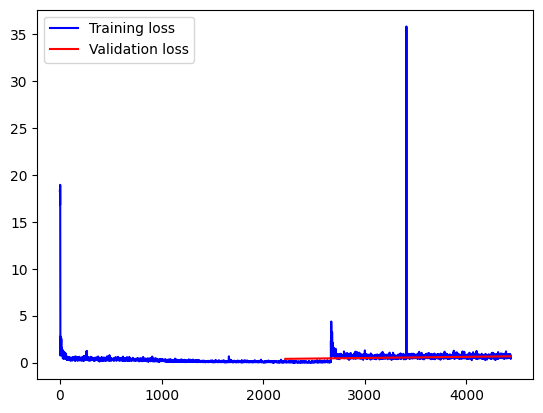

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data = history, color = "blue", label = "Training loss")
sns.lineplot(x = val_timesteps, y = val_history, color = "red", label = "Validation loss")
plt.legend()
plt.show()

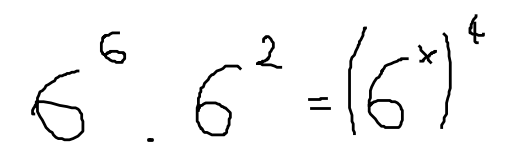

Prediction:



<IPython.core.display.Math object>

Gt:
${6^{6}} \cdot {6^{2}} = {( {6^{x}} )^{4}}$


<IPython.core.display.Math object>

In [9]:
import random
# Randomly select a validation image and caption
idx = random.randint(0, len(val_ds.labels_val))
img_name = os.path.join(val_ds.img_dir, val_ds.labels_val.iloc[idx, 1])
image = Image.open(img_name).convert('RGB')
caption = val_ds.labels_val.iloc[idx, 0]

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))
print("Gt:")
print(caption)
display(Math(caption))

### Validation on REAL handwritten digits

In [7]:
model = VisionEncoderDecoderModel.from_pretrained("../models/trocr-large-finetuned-math-captions").to(device)
processor = TrOCRProcessor.from_pretrained("../models/trocr-large-finetuned-math-captions")

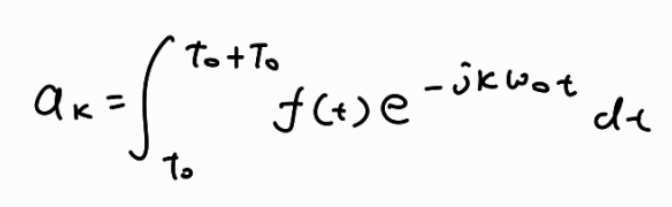

Prediction:
$a_{k} = \int_{t_{0}}^{t_{0}} + T_{0}} f(t) e^{-j k {u_{0}}$d_{t}$


<IPython.core.display.Math object>

In [17]:
import random
# Accuracy so far: 3/8
image = Image.open("../handwritten_val/q7.png").convert('RGB')

from IPython.display import display, Math, Latex
# Show image
display(image)

pixel_values = processor(images = image, return_tensors="pt").pixel_values.to(device)
out = model.generate(pixel_values, max_new_tokens = 256)
print("Prediction:")
pred = processor.decode(out[0], skip_special_tokens=True).replace("\\ ", "\\")
print(pred)
display(Math(pred))